
# Time Series forecasting with Linear Regression: Trends

Following along with Ryan Holbrook's tutorial [on Kaggle](https://www.kaggle.com/code/ryanholbrook/trend).

The data is found [here](https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series/data).

Stage 2 of several.

### Setup

Setup, importing and preprocessing the data.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from pathlib import Path
from statsmodels.tsa.deterministic import DeterministicProcess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


class PreProcessor:
    d_types = {
        "store_nbr": "category",
        "family": "category",
        "sales": "float32",
        "onpromotion": "uint64",
    }
    file_path = Path("./data/exercise2")
    _store_sales_per_day = None
    _avg_store_sales = None
    _retail_sales = None
    _food_retail_sales = None

    @classmethod
    def store_sales_per_day(cls):
        if cls._store_sales_per_day is not None:
            return cls._store_sales_per_day

        data = pd.read_csv(
            cls.file_path / "train.csv", dtype=cls.d_types, parse_dates=["date"]
        )
        data = data.set_index("date").to_period("D")
        data = data.set_index(["store_nbr", "family"], append=True)
        cls._store_sales_per_day = data
        return cls._store_sales_per_day

    @classmethod
    def avg_store_sales(cls):
        if cls._avg_store_sales is not None:
            return cls._avg_store_sales

        data = cls.store_sales_per_day()
        data = data.groupby("date").mean()["sales"]
        cls._avg_store_sales = data
        return cls._avg_store_sales

    @classmethod
    def retail_sales(cls):
        if cls._retail_sales is not None:
            return cls._retail_sales

        data = pd.read_csv(
            cls.file_path / "us-retail-sales.csv",
            parse_dates=["Month"],
            index_col="Month",
        ).to_period("D")
        cls._retail_sales = data
        return cls._retail_sales

    @classmethod
    def food_retail_sales(cls):
        if cls._food_retail_sales is not None:
            return cls._food_retail_sales

        data = cls.retail_sales()
        data = data.loc[:, "FoodAndBeverage"]
        cls._food_retail_sales = data
        return cls._food_retail_sales


class LinRegression:
    @classmethod
    def run(cls, x, y, x_forecast):
        model = LinearRegression()
        model.fit(x, y)
        y_pred = pd.Series(model.predict(x), index=x.index)
        y_forecast = pd.Series(model.predict(x_forecast), index=x_forecast.index)

        r2 = r2_score(y, y_pred)
        f_values, p_values = f_regression(x, y)
        p_value = p_values[0]

        return model, y_pred, y_forecast, r2, p_value

### Long term trends and a rolling average

Lets plot the monthly sales of food and beverages to see if there are any long term trends.

It looks parabolic to me.

<Axes: xlabel='Month'>

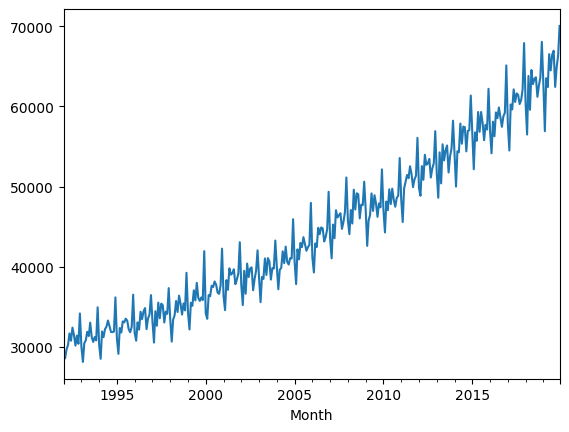

In [25]:
food_sales = PreProcessor.food_retail_sales()
food_sales.plot()

Now we make a rolling average, to better visualize the trend and smooth out seasonal variations.

<Axes: title={'center': 'Food Sales - 365-Day Moving Average'}, xlabel='Month'>

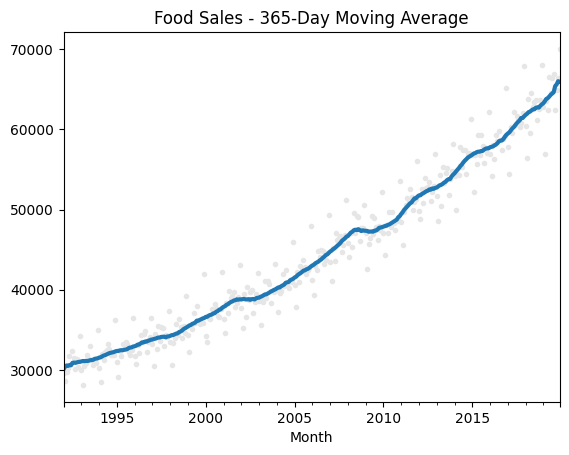

In [26]:
rolling_avg_food_sales = food_sales.rolling(
    window=12, center=True, min_periods=6
).mean()

ax = food_sales.plot(style=".", color="0.9")
rolling_avg_food_sales.plot(
    ax=ax,
    linewidth=3,
    title="Food Sales - 365-Day Moving Average",
    legend=False,
)

It looks like a complex trend but, still slightly parabolic to me.

Which could be model as a percentage change, a compounding effect. In carrot sales, not stock value alas.

## Creating a Trend Feature

Back to using the average monthly sales data now from the previous notebook.

Lets create a time step feature using DeterministicProcess, a more typical way to do so that handles edge cases. The data we're modelling may have a cubic trend (the tutorial just says so, but could have plotted it to see), so we create a cubic matrix of the time steps.

Then we fit a linear model to the cubic features and the target, and plot the predictions.

In [27]:
y = PreProcessor.avg_store_sales()

# Create a time step feature, converting all timestamps to an integer series
dp = DeterministicProcess(index=y.index, order=3)
# This is a matrix of the time step and it ^2 and ^3, for all timestamps in the sample
x = dp.in_sample()
# Same matrix but for the next 90 steps (months)
x_forecast = dp.out_of_sample(steps=90)

x.head()

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.0
2013-01-02,2.0,4.0,8.0
2013-01-03,3.0,9.0,27.0
2013-01-04,4.0,16.0,64.0
2013-01-05,5.0,25.0,125.0


R^2: 0.524526183140755
F p-value: 0.000%


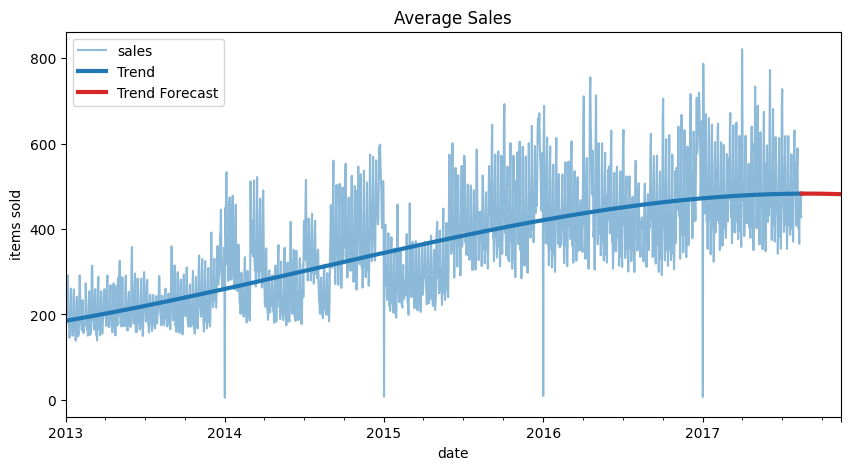

In [28]:
model, y_pred, y_forecast, r2, p_value = LinRegression.run(x, y, x_forecast)

fig, ax = plt.subplots(figsize=(10, 5))
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
ax.legend()

print(f"R^2: {r2}")
print("F p-value: {:.3f}%".format(p_value * 100))
fig.show()

The trend of increasing sales of years is apparent. We can see the forecast showing a decline in 2018.

It could be cubic, a stretched cubic function. It's not clear.

### Higher orders are not always better

One way to fit a complex trend is to use higher orders.

However, the higher the order the worse the forecasting will be.

High power functions can fit the training data well, passing close to each point. However, they're global functions where changing behaviour in one part affects the whole curve. The higher powers dominate as you move away from the origin (sample).

Lets see that demonstrated.

Here is a nice fit of a 11th order polynomial/function.

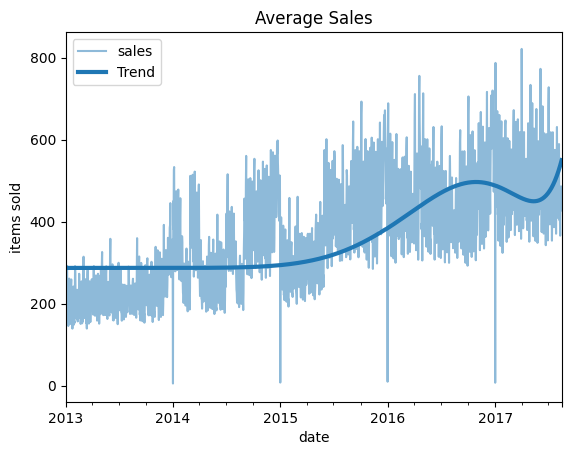

In [31]:
dp = DeterministicProcess(index=y.index, order=11)
x = dp.in_sample()
x_forecast = dp.out_of_sample(steps=90)
model, y_pred, y_forecast, r2, p_value = LinRegression.run(x, y, x_forecast)

ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax.legend()

But now lets forecast with it. 

See how it's running wild in the forecast, based on whatever happened recently in the past.

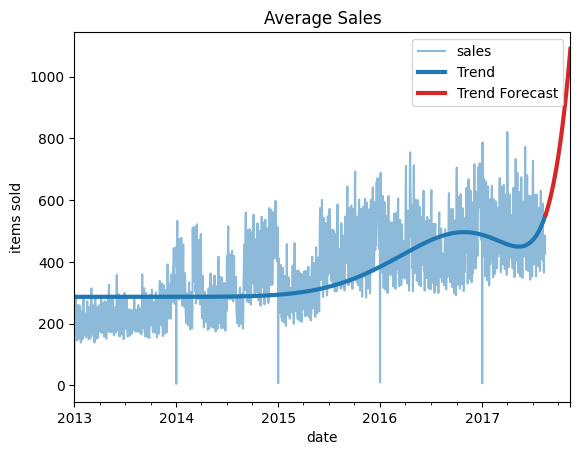

In [32]:
ax = y.plot(alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color="C0")
ax = y_forecast.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
ax.legend()